In [1]:
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2
import numpy as np
from utils.load_deepdeform import load_deepdeform_data
import OpenEXR as exr
import imageio
import Imath
import matplotlib.pyplot as plt
import torch
images, depth_maps, poses, times, render_poses, render_times, hwff, i_split = load_deepdeform_data('./data/human', True, 1, 'spiral')
#print(f"[Info] Loaded DeepDeform:\n\t\timages.shape: {images.shape}\n\t\trender_poses.shape: {render_poses.shape}\n\t\thwff: {hwff}\n\t\targs.datadir: {args.datadir}")
i_train, i_val, i_test = i_split
near = 0.1
far = np.max(depth_maps) + 0.1
print("===HERE===")
print(f"[Info] Setting near plane at distance {near} and far plane at distance {far}.")
print(depth_maps)

===HERE===
[Info] Setting near plane at distance 0.1 and far plane at distance 2.0866502285003663.
[[[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.83250755]
   [0.83168179]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.83402145]
   [0.83319569]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.41632259]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   .

{'Depth': HALF (1, 1)}


/home/kirwul/miniconda3/envs/dnerf/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


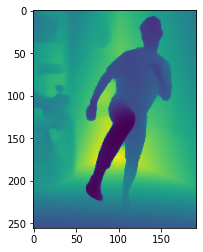

In [9]:
depth = exr.InputFile('data/EXR_RGBD/depth/160.exr')
header = depth.header()
dw = header['dataWindow']
isize = (dw.max.y - dw.min.y + 1, dw.max.x - dw.min.x + 1)
print(header['channels'])
for c in header['channels']:
    C = depth.channel(c, Imath.PixelType(Imath.PixelType.FLOAT))
    C = np.fromstring(C, dtype=np.float32)
    C = np.reshape(C, isize)
plt.imshow(C)

In [35]:
n = np.array([[2,2,3],[2,2,3]])
print(n.shape)

(2, 3)


In [62]:
import os
from pathlib import Path
import shutil
import torch
import numpy as np
import imageio 
import json
import torch.nn.functional as F
import cv2
import math

from load_blender import trans_t, rot_phi, rot_theta

datadir="data/EXR_RGBD"
start_frame_i=0
end_frame_i=403
step=1
train_p=0.7
val_p=0.15
test_p=0.15

def quat_and_trans_2_trans_matrix(Q):
    """
    Covert a quaternion plus transformation vector into a full four-dimensional translation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion and translation vector (q0,q1,q2,q3,tx,ty,tz) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[0]
    q1 = Q[1]
    q2 = Q[2]
    q3 = Q[3]
    tx = Q[4]
    ty = Q[5]
    tz = Q[6]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    trans_matrix = np.array([[r00, r01, r02, tx],
                           [r10, r11, r12, ty],
                           [r20, r21, r22, tz],
                           [0,0,0,1]])
                            
    return trans_matrix

def pose_spherical2(alpha, beta, radius):
    """Computes camera poses on a sphere around the world coordinate origin without spherical coordinates.

    Args:
        alpha (float): Rotation about the X-axis.
        beta (float): Rotation about the Y-axis.
        radius (float): Translation in the radial (Z) direction.

    Returns:
        c2w: 4x4 Tensor. The camera-to-world homogeneous transformation matrix.
    """
    c2w = trans_t(radius)
    c2w = rot_phi(alpha/180.*np.pi) @ c2w
    c2w = rot_theta(-beta/180.*np.pi) @ c2w
    return c2w


def pose_spiral(theta, z_cam, z_cam_glob, H, W):
    """Computes camera poses that spiral out from the fixed training pose at (0, 0, z_glob) in the direction 
    of the world coordinate origin and stay inside of the training camera's visibility cone.

    Args:
        theta (float): Angle of rotation about Z_cam in degrees.
        z_cam (float): Distance in Z in camera coordinates.
        z_cam_glob (float): Distance in Z from global coordinate origin to the training camera.
        H (int): Image height.
        W (int): Image width.

    Returns:
        c2w: 4x4 Tensor.
    """
    # in camera coordinates
    lim = min(H/W, W/H)
    x_c = z_cam * lim * np.cos(theta * np.pi/180)
    y_c = z_cam * lim * np.sin(theta * np.pi/180)
    # in world coordinates 
    x_w, y_w, z_w, _ = (trans_t(z_cam_glob) @ torch.Tensor([x_c, y_c, z_cam, 1])).cpu()
    alpha = - np.arctan(y_w/z_w) * 180/np.pi     # is rotation about X_global
    beta = np.arctan(x_w/z_w) * 180/np.pi      # rotation about Y_global
    radius = np.sqrt(x_w**2 + y_w**2 + z_w**2)
    c2w = pose_spherical2(alpha, beta, radius)
    return c2w#, (x_w, y_w, z_w)

rgb_paths = sorted(os.listdir(os.path.join(datadir, "color")))[start_frame_i:end_frame_i:step]
depth_paths = sorted(os.listdir(os.path.join(datadir, "depth")))[start_frame_i:end_frame_i:step]
if not end_frame_i:
    end_frame_i = len(rgb_paths) - 1
assert len(rgb_paths) == len(depth_paths), "Unequal number of RGB and depth frames."

frames = [{"rgb": os.path.join(datadir, "color", rgb), "d": os.path.join(datadir, "depth", d), "t": t} 
                for rgb, d, t in zip(rgb_paths, depth_paths, np.linspace(0, 1, len(rgb_paths)))]
np.random.shuffle(frames)

# Create train-val-test splits from shuffled frames and then sort by time
splits = {
    "train": sorted(frames[:int(len(frames)*train_p)], key=lambda x: x["t"]), 
    "val": sorted(frames[int(len(frames)*train_p):int(len(frames)*(train_p+val_p))], key=lambda x: x["t"]), 
    "test": sorted(frames[int(len(frames)*(train_p+val_p)):], key=lambda x: x["t"]),
}
print(f"Creating {int(train_p*100)}-{int(val_p*100)}-{int(test_p*100)}-Split with {len(splits['train'])}-{len(splits['val'])}-{len(splits['test'])} images.")

with open("data/EXR_RGBD" + "/metadata.json", "r") as f:
        metas = json.load(f)

        K_matrix = np.array(metas["K"]).astype(np.float32)
        f_x = K_matrix[0]
        f_y = K_matrix[4]

        #init_pose = metas["initPose"]
        #transform_matrix = quat_and_trans_2_trans_matrix(init_pose) #J: i think it is in m
        #transform_matrix[2, 3] = SCENE_OBJECT_DEPTH #FIXME J: To set training cam higher

        init_pose = np.identity(4)
        init_pose[2,3] = 1
        
        poses = np.array(metas["poses"]).astype(np.float32)
        print(poses.shape)
        
        transform_matrix = np.zeros(shape=(len(splits["train"]+splits["val"]+splits["test"]),4,4))
        z=0
        k=[]
        for s in splits:
            for i, frame in enumerate(splits[s]):
                transform_matrix[z] = quat_and_trans_2_trans_matrix(poses[z])
                z += 1
print(transform_matrix)

Creating 70-15-15-Split with 282-60-61 images.
(404, 7)
[[[-1.00000000e+00  5.61850433e-09 -4.46143211e-09  0.00000000e+00]
  [-5.61850433e-09 -1.00000000e+00  1.99319880e-10  0.00000000e+00]
  [-4.46143211e-09  1.99319908e-10  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[-9.99998010e-01  1.36432622e-03  1.45539746e-03  1.33252144e-03]
  [-1.36445498e-03 -9.99999065e-01 -8.74347606e-05  3.32191586e-04]
  [ 1.45527686e-03 -8.94204131e-05  9.99999046e-01 -1.51886046e-03]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[-9.99989092e-01  2.77606398e-03  3.75634152e-03  2.77829170e-03]
  [-2.77782325e-03 -9.99996035e-01 -4.63169854e-04  4.32342291e-04]
  [ 3.75504093e-03 -4.73599270e-04  9.99992847e-01 -3.24727595e-03]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 ...

 [[ 2.01908588e-01  3.84147406e-01  9.00923550e-01  1.40154493e+00]
  [ 3.81030262e-01 -8.78211223e-01  2.89069086e-

In [9]:
x = torch.randn(2, 3)
y = torch.randn(2, 3)
z = torch.cat((x,y), -1)
print(x)
print(z)


tensor([[-0.8428,  0.4026,  0.6987],
        [-0.7368,  0.6860, -0.3774]])
tensor([[-0.8428,  0.4026,  0.6987,  0.2912,  0.5059,  0.0318],
        [-0.7368,  0.6860, -0.3774, -1.9224, -2.7906, -0.5822]])
